In [1]:
import numpy as np
import pandas as pd
import itertools
import gc
import psycopg2
import getpass
# for configuring connection 
from configobj import ConfigObj
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = '192.168.60.144'
    conn_info["sqlport"] = 6432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == '192.168.60.144') & (conn_info["sqlport"]=='6432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [3]:
from sqlalchemy import create_engine,text

con = create_engine(
    f'postgresql://{conn_info["sqluser"]}:{conn_info["sqlpass"]}@{conn_info["sqlhost"]}:{conn_info["sqlport"]}/{conn_info["dbname"]}',
    connect_args={'options': '-c search_path=eicu_crd'}
)

In [4]:
create_table_query = query_schema +"""
drop materialized view if exists vitals cascade;
create materialized view vitals as
select vp.patientunitstayid as patient, vp.observationoffset, vp.temperature, vp.sao2, vp.heartrate, vp.respiration, vp.cvp,
    vp.systemicsystolic, vp.systemicdiastolic, vp.systemicmean, vp.st1, vp.st2, vp.st3
from vitalperiodic as vp
    -- select only the patients who are in the cohort
inner join drug as d
      on d.patient = vp.patientunitstayid
where vp.observationoffset > 0
order by vp.patientunitstayid, vp.observationoffset;
"""

with con.begin() as connection:  
    connection.execute(text(create_table_query))
    
select_query = "SELECT * FROM vitals;"
df_vitalp = pd.read_sql_query(select_query, con)

print("there are {} patiets and {} records".format(df_vitalp["patient"].nunique(),df_vitalp["patient"].count()))

there are 22598 patiets and 15080425 records


In [5]:
timeseries_periodic = df_vitalp.copy()
timeseries_periodic.set_index(['patient','observationoffset'], inplace=True)
timeseries_periodic.rename(round_up, level = 'observationoffset', inplace = True)
timeseries_periodic.sort_index(inplace=True)

In [6]:
periodic =process_vital_signs(timeseries_periodic,'observationoffset')

==> Reconfiguring periodic timeseries...
==> Filtering out invalid values with the possible value ranges...
There are 22598 patients and 14692344 records in the vital periodic table.
==> Filtering out outliers...
select valid vlaue of vital signs
There are 22598 patients and 14692344 records in the vital periodic table.
==> Normalizing data...


In [7]:
min_time = periodic.index.get_level_values('time').min()
max_time = periodic.index.get_level_values('time').max()
print('Time range:', min_time, max_time)

Time range: 0 days 00:00:00 10 days 03:20:00


## analysis the periodic data

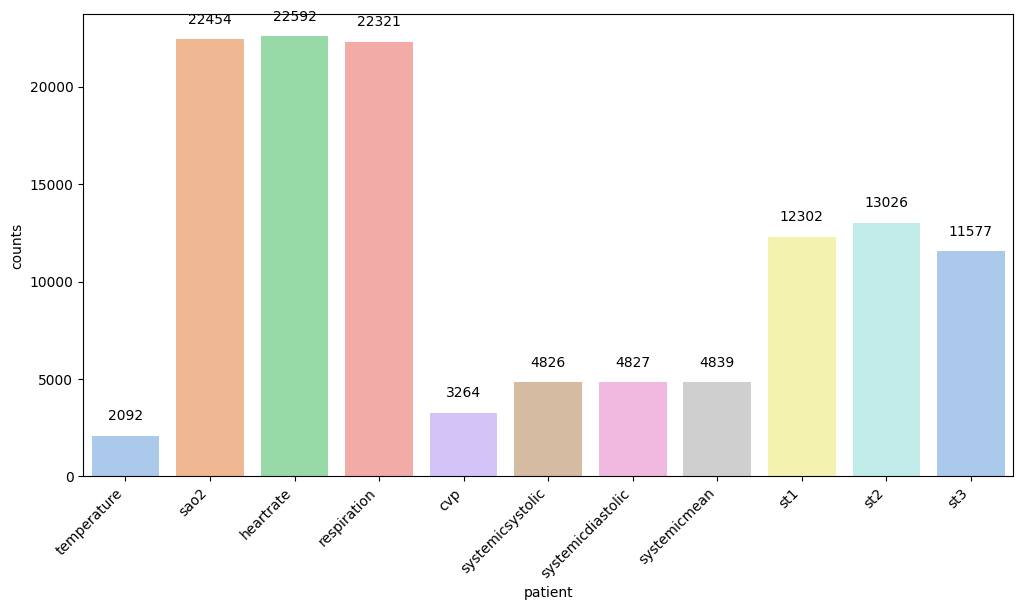

In [8]:
patient_counts = periodic.groupby('patient').count() > 0 
patient_counts = patient_counts.sum()  

plot_counts(patient_counts, 'patient')

##  collect time step

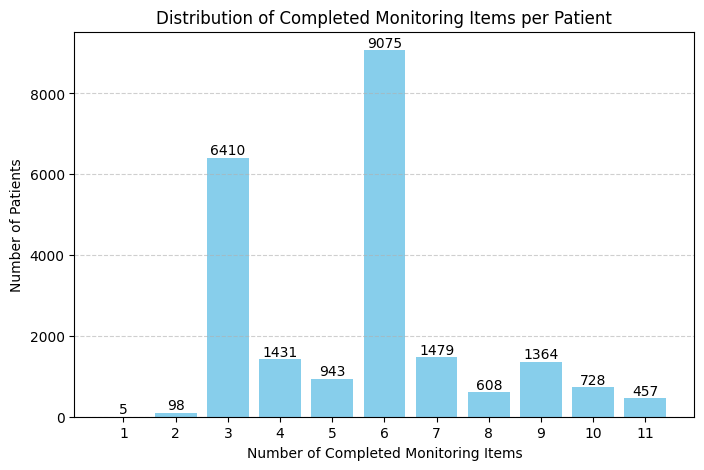

In [11]:
patient_non_null= count_completed_rows(periodic)

In [12]:
## delete the patient with less than 6 records
min_records = 6
valid_patients = patient_non_null[patient_non_null >= min_records].index
periodic_6 = periodic.loc[valid_patients]
print(f"there are {len(valid_patients)} patients with at least {min_records} records in the periodic table and {len(periodic_6)} records in the table.")

there are 13711 patients with at least 6 records in the periodic table and 9108946 records in the table.


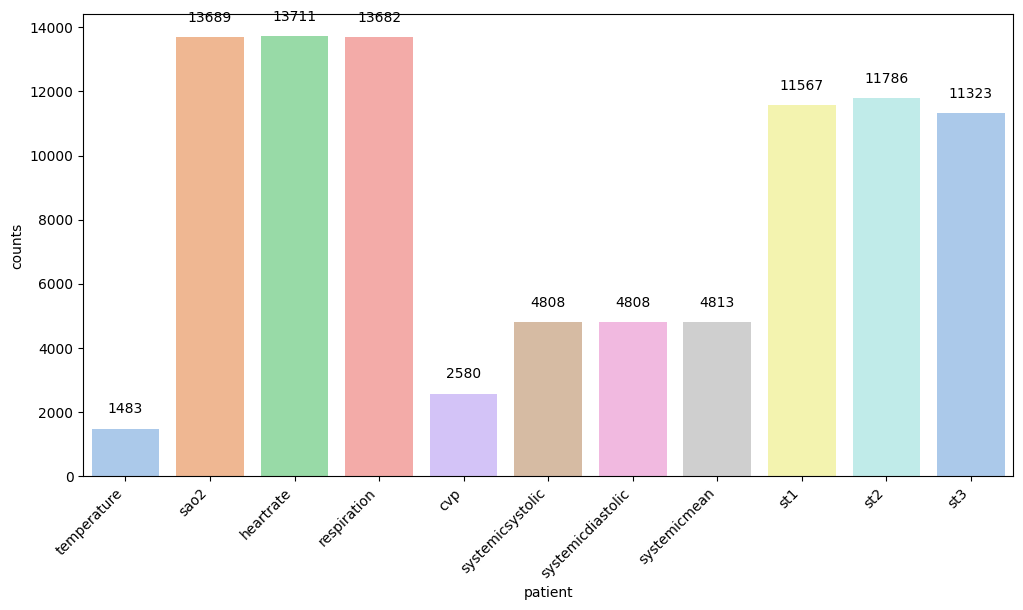

In [13]:
patient_6_counts = periodic_6.groupby('patient').count() > 0 
patient_6_counts = patient_6_counts.sum()  
plot_counts(patient_6_counts, 'patient')

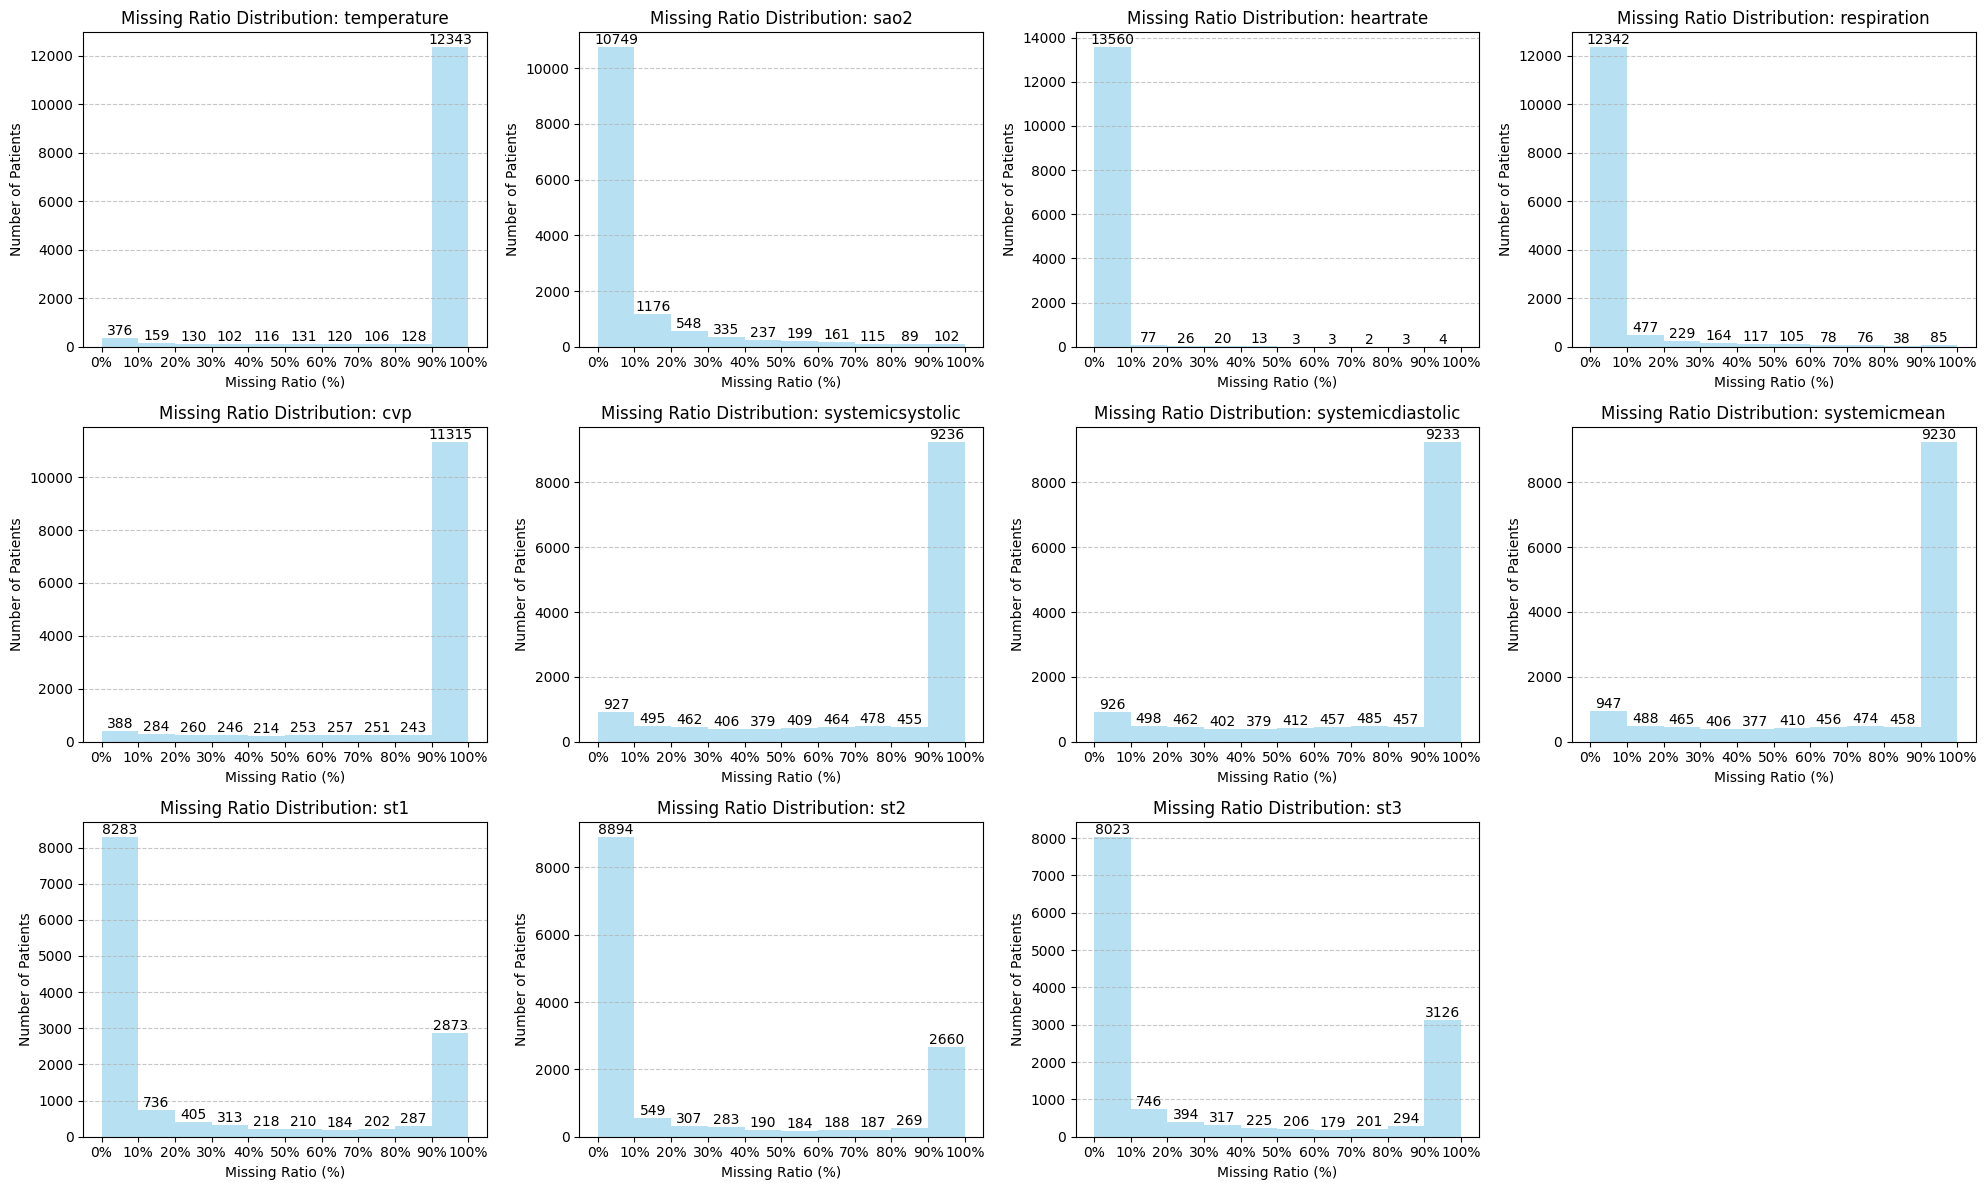

In [14]:
missing_ratios_6 = periodic_6.groupby(level=0).apply(missing_ratio)
plot_missing_ratio_distribution(missing_ratios_6)

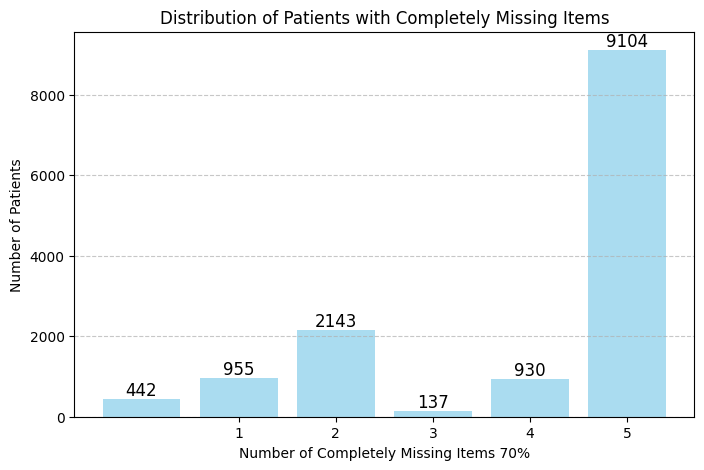

the selected columns are ['temperature', 'cvp', 'systemicsystolic', 'systemicdiastolic', 'systemicmean']


In [16]:
plot_missing_ratio_completed_items( periodic_6, ratio=70)

In [17]:
selected_cols = ['temperature', 'cvp', 'systemicsystolic', 'systemicdiastolic', 'systemicmean']
patient_missing_ratio = periodic_6[selected_cols].isna().groupby(level=0).mean() * 100
patients_to_remove = patient_missing_ratio[patient_missing_ratio.mean(axis=1) >= 70].index
periodic_6_7 = periodic_6.drop(index=patients_to_remove, level=0)

print(f"Removed {len(patients_to_remove)} patients with more than 70% missing values in the periodic table. The remaining table has {len(periodic_6_7)} records and {len(periodic_6_7.index.get_level_values(0).unique())} patients.")

Removed 10621 patients with more than 70% missing values in the periodic table. The remaining table has 2105085 records and 3090 patients.


## further processing

In [18]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
periodic_6_7.to_hdf(hdf + 'vital_6_8.h5', key='vital_6_8', mode='w', format='table')

In [ ]:
patients = periodic_6_7.index.unique(level=0)
gen_chunks = gen_patient_chunk(patients,  periodic_6_7)
header = True
print('==> Initiating main processing loop...')

for i, patient_chunk in enumerate(gen_chunks, start=1):
    final = resample(patient_chunk)
    final.to_hdf(hdf + "vital_signs.h5", key="df", mode="a", complevel=5, complib="zlib", format="table", append=True)

    print(f'==> Processed {i * 500} patients...')
    
    del patient_chunk # free up memory
    gc.collect()

==> Initiating main processing loop...
==> Processed 500 patients...
==> Processed 1000 patients...
==> Processed 1500 patients...
==> Processed 2000 patients...
==> Processed 2500 patients...
==> Processed 3000 patients...
==> Processed 3500 patients...


In [34]:
vital= pd.read_hdf(hdf+ "vital_signs.h5", key="df") 

In [37]:
with con.begin() as conn:
    conn.execute(text("DROP MATERIALIZED VIEW IF EXISTS vitalp CASCADE;"))
    conn.execute(text("DROP TABLE IF EXISTS temp_vitalp CASCADE;"))
 
columns = ','.join([f'{col}' for col in vital.columns])
vital.to_sql("temp_vitalp", con, if_exists="replace", index=True, method="multi")   

create_table_sql = f"""
DROP TABLE IF EXISTS vitalp CASCADE;
create materialized view vitalp as
SELECT 
    patient, {columns}									
FROM temp_vitalp;
"""
with con.begin() as connection:
    connection.execute(text(create_table_sql))
    
select_query = "SELECT * FROM vitalp;"
df_vp = pd.read_sql_query(select_query, con)
print("there are {} patiets and {} records".format(df_vp["patient"].nunique(),df_vp["patient"].count()))

there are 3090 patiets and 2298678 records


In [ ]:
vital

temperature      sao2  heartrate  respiration       cvp  \
patient time                                                            
260132  1        0.500000  0.930000   0.270614     0.498113  0.482500   
        2        0.500000  0.930000   0.270614     0.498113  0.482500   
        3        0.500000  0.930000   0.270614     0.498113  0.482500   
        4        0.500000  0.930000   0.270614     0.498113  0.482500   
        5        0.500000  0.930000   0.270614     0.498113  0.482500   
...                   ...       ...        ...          ...       ...   
3247116 2328     0.142661  0.890286   0.602807     0.443774  0.854000   
        2329     0.142787  0.890476   0.601974     0.444182  0.854167   
        2330     0.142923  0.889441   0.601449     0.432322  0.854348   
        2331     0.143011  0.888312   0.600080     0.433962  0.852273   
        2332     0.143108  0.887075   0.598580     0.434861  0.847619   

              systemicsystolic  systemicdiastolic  systemicmean  st1  \
patient time                                                           
260132  1             0.040419           0.027727      0.014964  0.5   
        2             0.040419           0.027727      0.014964  0.5   
        3             0.040419           0.027727      0.014964  0.5   
        4             0.040419           0.027727      0.014964  0.5   
        5             0.040419           0.027727      0.014964  0.5   
...                        ...                ...           ...  ...   
3247116 2328          0.581317           0.396000      0.463358  0.5   
        2329          0.581587           0.397348      0.464416  0.5   
        2330          0.576412           0.394466      0.459854  0.5   
        2331          0.570495           0.391322      0.455209  0.5   
        2332          0.565726           0.389177      0.451860  0.5   

                   st2  st3  
patient time                 
260132  1     0.016237  0.5  
        2     0.016237  0.5  
        3     0.016237  0.5  
        4     0.016237  0.5  
        5     0.016237  0.5  
...                ...  ...  
3247116 2328  0.500000  0.5  
        2329  0.500000  0.5  
        2330  0.500000  0.5  
        2331  0.500000  0.5  
        2332  0.500000  0.5  

[2298678 rows x 11 columns]

In [9]:
query = query_schema + """
SELECT * FROM vitalp;
"""

df_vp = pd.read_sql_query(query, con)

In [ ]:
with con.begin() as conn:
    conn.execute(text("DROP MATERIALIZED VIEW IF EXISTS id CASCADE;"))
    conn.execute(text("DROP TABLE IF EXISTS temp_id CASCADE;"))
 
df_vp.to_sql("temp_id", con, if_exists="replace", index=True, method="multi")   

create_table_sql = f"""
DROP TABLE IF EXISTS id CASCADE;
create materialized view id as
SELECT 
    DISTINCT(patient)									
FROM temp_id;
"""
with con.begin() as connection:
    connection.execute(text(create_table_sql))
    


there are 3090 patiets and 2298678 records


In [16]:
select_query = "SELECT * FROM id;"
df_id = pd.read_sql_query(select_query, con)
print("there are {} patiets and {} records".format(df_id["patient"].nunique(),df_id["patient"].count()))

there are 3090 patiets and 3090 records


In [ ]:
import pandas as pd
import numpy as np

periodic = periodic.reset_index()
unique_ids = periodic["patient"].unique()

np.random.seed(42)
shuffled_ids = np.random.permutation(unique_ids)

print(shuffled_ids.shape[0])
n = shuffled_ids.shape[0]
train_end = int(0.70 * n)
val_end = train_end + int(0.15 * n)

train_ids = shuffled_ids[:train_end]
val_ids = shuffled_ids[train_end:val_end]
test_ids = shuffled_ids[val_end:]

train_set = periodic[ periodic["patient"].isin(train_ids) ]
val_set   = periodic[ periodic["patient"].isin(val_ids) ]
test_set  = periodic[ periodic["patient"].isin(test_ids) ]
print(train_set.shape, val_set.shape, test_set.shape)

In [ ]:
import h5py
import os

def save_ts_to_h5py(data_path,timeseries_data,partation):
    
    output_file = os.path.join(data_path, 'vital_signs_{}.h5'.format(partation))
    with h5py.File(output_file, 'w') as h5f:
        for patient_id, group in timeseries_data.groupby('patient'):
            data_array = group.values 
            h5f.create_dataset(str(patient_id), data=data_array)
    
    print(f'Data saved successfully in h5py version!')

In [ ]:
ts_path = '/home/mei/nas/docker/thesis/data/hdf/ts/'

save_ts_to_h5py(ts_path,train_set,'train')
save_ts_to_h5py(ts_path,val_set,'val')
save_ts_to_h5py(ts_path,test_set,'test')

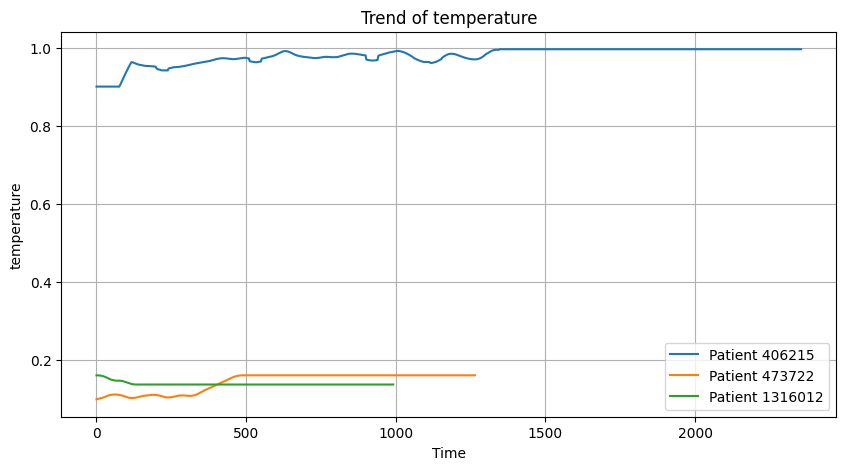

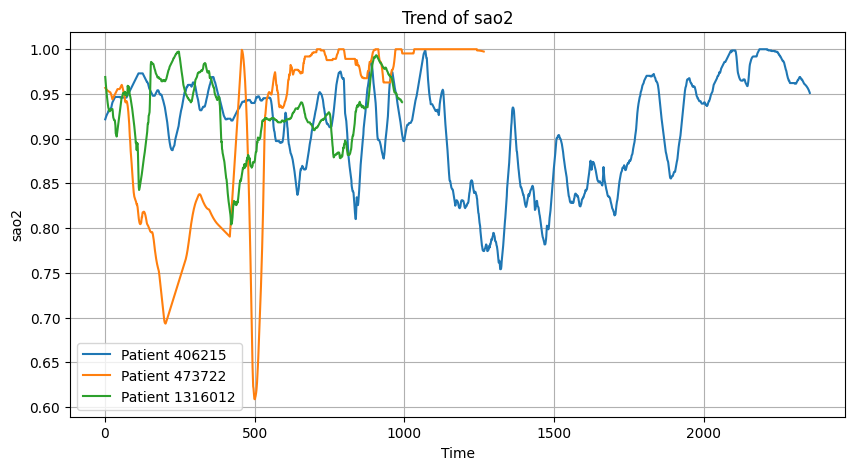

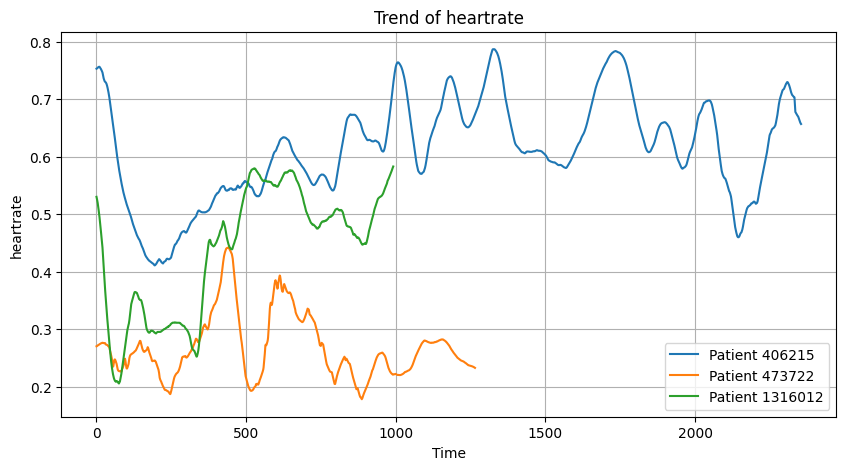

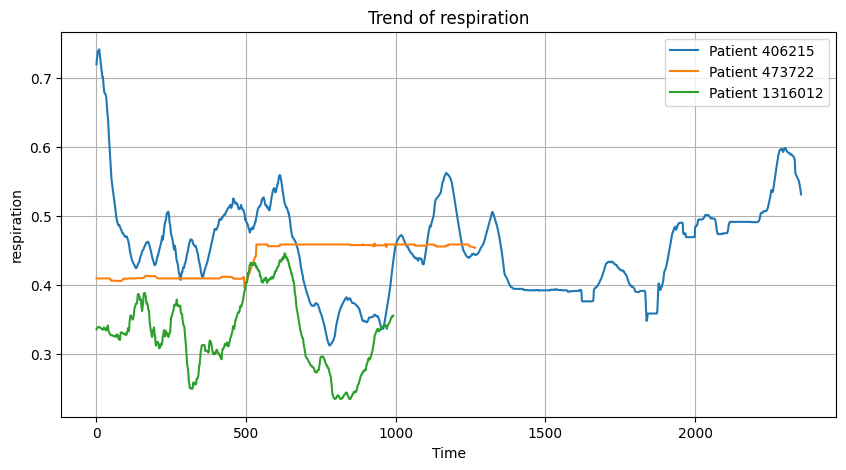

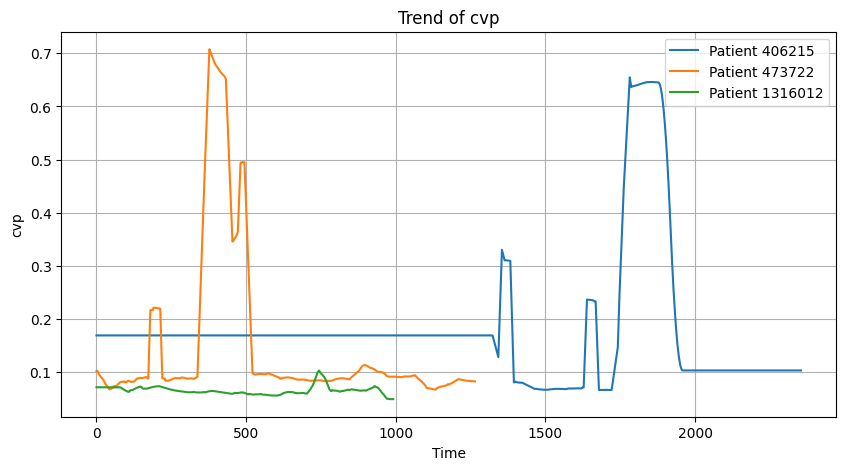

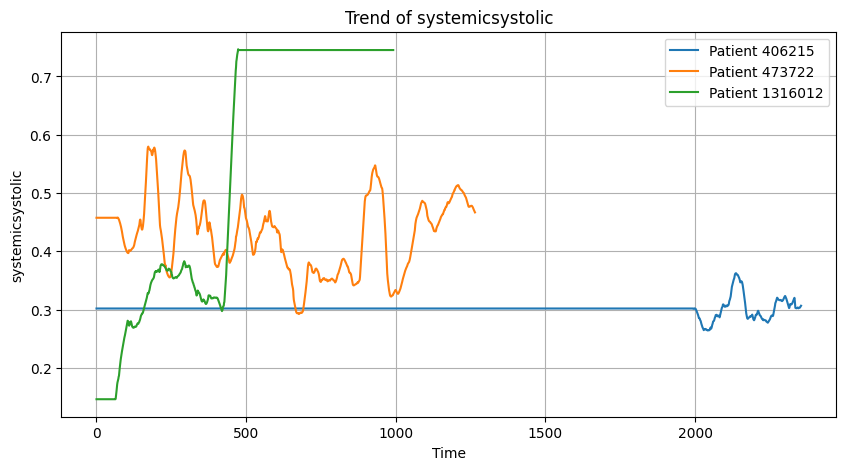

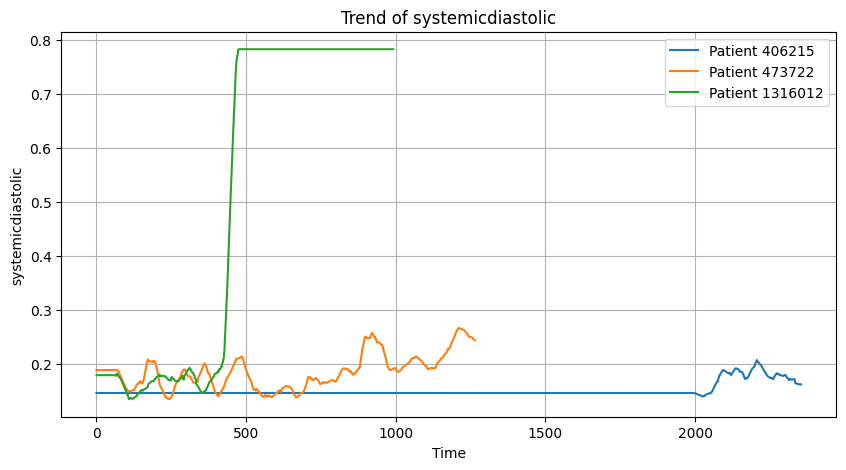

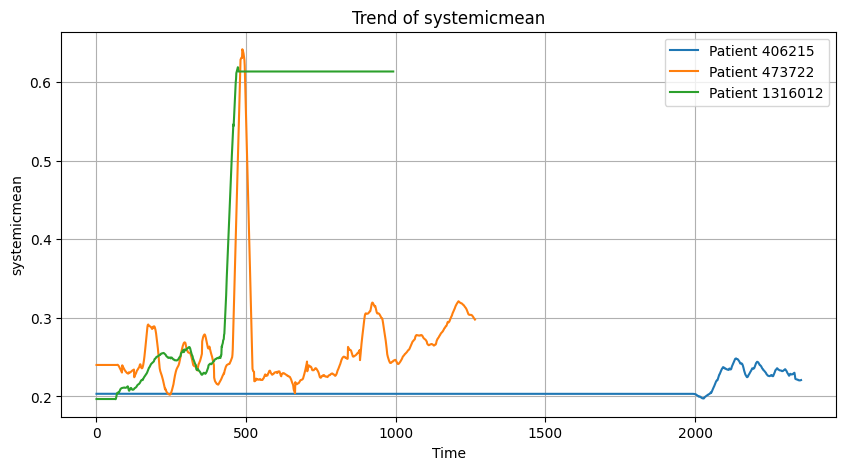

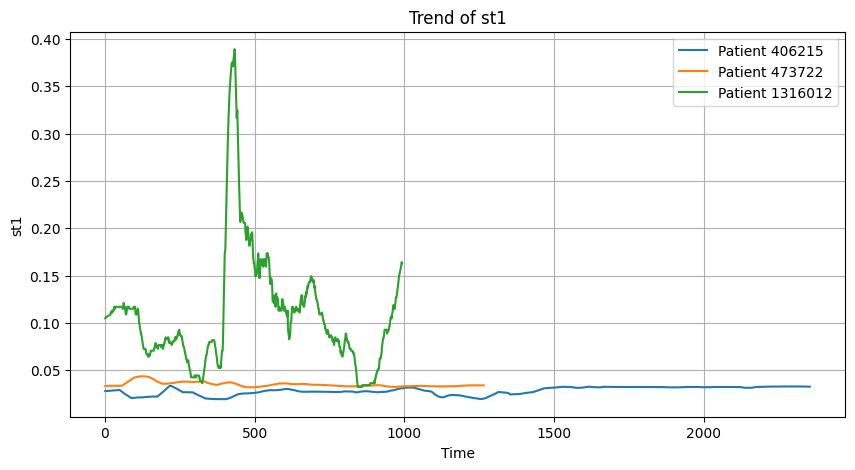

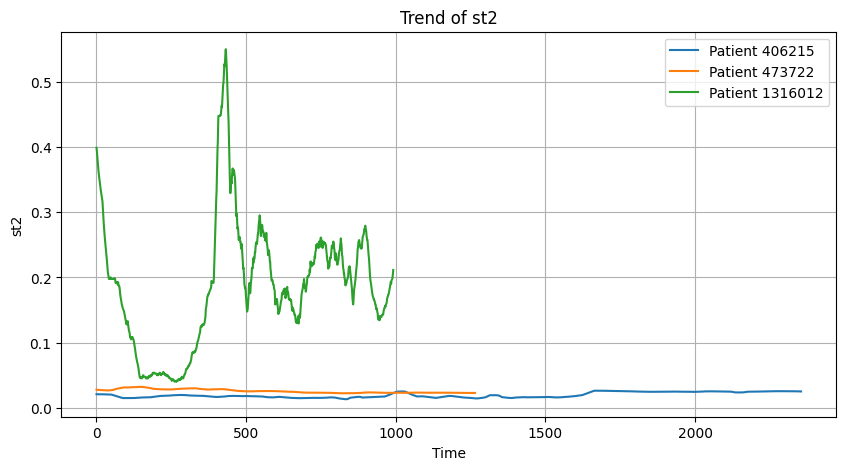

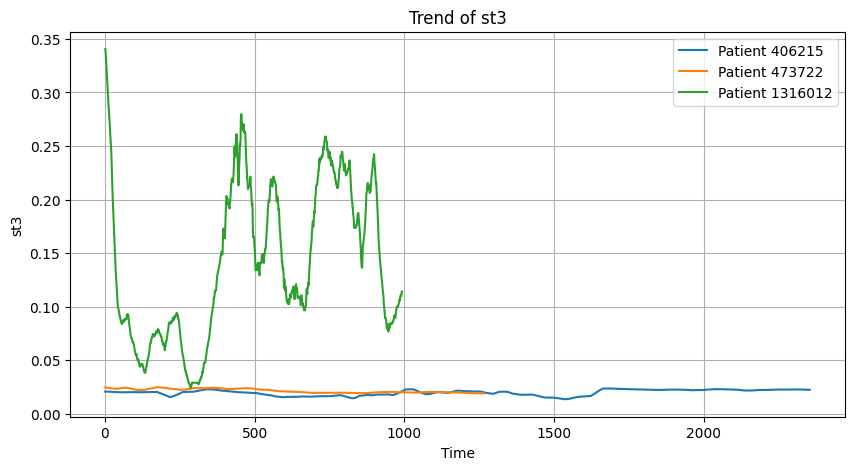

In [113]:
final_ts = final_ts.reset_index()
patients = final_ts["patient"].unique()[:3]

feature_cols = [col for col in final_ts.columns if col not in ["patient", "time"]]

for feature in feature_cols:
    plt.figure(figsize=(10, 5))
    for patient in patients:
        patient_data = final_ts[final_ts["patient"] == patient].sort_values("time")
        plt.plot(patient_data["time"], patient_data[feature], label=f'Patient {patient}')
    plt.title(f"Trend of {feature}")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()